In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

# RNN (Recurrent Neural Network)
---

Feedback loop to have some memory through the steps.

In [9]:
class RNNCell(nn.Module):
    def __init__(self, input_size: int, memory_size: int):
        super().__init__()
        self.memory_size = memory_size
        self.fc = nn.Linear(input_size + memory_size, memory_size)
    
    def forward(self, xs, ms):
        return self.fc(torch.cat((xs, ms), dim=-1))

    
class RNNLayer(nn.Module):
    def __init__(self, input_size: int, memory_size: int):
        super().__init__()
        self.cell = RNNCell(input_size, memory_size)
    
    def forward(self, xs):
        batch_size, input_size, sequence_len = xs.shape
        h = torch.zeros(size=(batch_size, self.cell.memory_size))
        for i in range(sequence_len):
            x = xs[:,:,i]
            h = self.cell(x, h)
        return h


rnn = RNNLayer(input_size=5, memory_size=5)
rnn(torch.zeros(size=(2, 5, 10)))

tensor([[ 0.3084, -0.1162,  0.1011, -0.3020, -0.2172],
        [ 0.3084, -0.1162,  0.1011, -0.3020, -0.2172]],
       grad_fn=<AddmmBackward>)

### Sample problem

Addition of a variable length list of vectors.

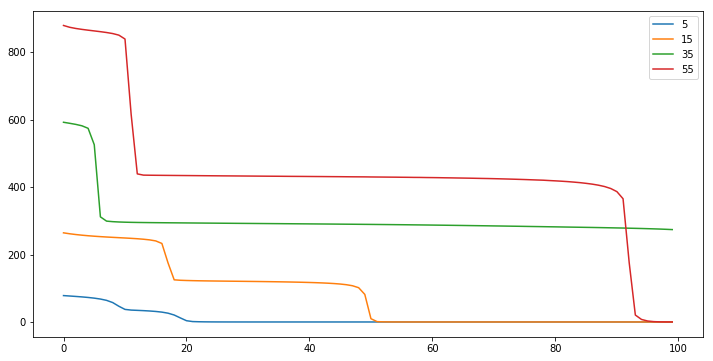

tensor([[1.5000, 0.5000]], grad_fn=<AddmmBackward>)
tensor([[1.5000, 0.5000]], grad_fn=<AddmmBackward>)
tensor([[1.0599, 0.3721]], grad_fn=<AddmmBackward>)
tensor([[1.5061, 0.5180]], grad_fn=<AddmmBackward>)


In [42]:
def train_rnn(model, train_xs, train_ys):
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    ds = data.TensorDataset(torch.FloatTensor(train_xs), torch.FloatTensor(train_ys))
    loader = data.DataLoader(ds, batch_size=100, shuffle=True)

    losses = []
    for _ in range(100):
        episode_loss = 0.
        for x, y in loader:
            y_pred = model(x)
            loss = criterion(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            episode_loss += loss.item()
        losses.append(episode_loss)
    return losses


# Simple test set
test_xs = torch.FloatTensor([[[1., 0., 0.5], [1., 0., -0.5]]])

# Training on 5 numbers
train_xs = np.random.uniform(-1, 1, size=(5000, 2, 5))
train_ys = np.apply_along_axis(lambda x: np.sum(x), -1, train_xs)
model1 = RNNLayer(input_size=2, memory_size=2)
losses1 = train_rnn(model1, train_xs, train_ys)

# Training on 15 numbers
train_xs = np.random.uniform(-1, 1, size=(5000, 2, 15))
train_ys = np.apply_along_axis(lambda x: np.sum(x), -1, train_xs)
model2 = RNNLayer(input_size=2, memory_size=2)
losses2 = train_rnn(model2, train_xs, train_ys)

# Training on 35 numbers
train_xs = np.random.uniform(-1, 1, size=(5000, 2, 35))
train_ys = np.apply_along_axis(lambda x: np.sum(x), -1, train_xs)
model3 = RNNLayer(input_size=2, memory_size=2)
losses3 = train_rnn(model3, train_xs, train_ys)

# Training on 55 numbers
train_xs = np.random.uniform(-1, 1, size=(5000, 2, 55))
train_ys = np.apply_along_axis(lambda x: np.sum(x), -1, train_xs)
model4 = RNNLayer(input_size=2, memory_size=2)
losses4 = train_rnn(model4, train_xs, train_ys)

# Showing the losses over time
plt.figure(figsize=(12,6))
plt.plot(list(range(len(losses1))), losses1, label='5')
plt.plot(list(range(len(losses2))), losses2, label='15')
plt.plot(list(range(len(losses3))), losses3, label='35')
plt.plot(list(range(len(losses4))), losses4, label='55')
plt.legend()
plt.show()

# Print the results
print(model1(test_xs))
print(model2(test_xs))
print(model3(test_xs))
print(model4(test_xs))

# LSTM
---

RNN problems is the propagation of gradient: need to have a carrier belt between the recursive cell, in which they can store the information.

* Original paper: https://www.bioinf.jku.at/publications/older/2604.pdf
* Helpful illustration: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
* Additions on GRUs: https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

In [50]:
class LSTMCell(nn.Module):
    def __init__(self, hidden_size: int, input_size: int):
        super().__init__()
        self.forget_gate = nn.Sequential(
            nn.Linear(hidden_size + input_size, hidden_size),
            nn.Sigmoid())
        self.adding_gate = nn.Sequential(
            nn.Linear(hidden_size + input_size, hidden_size),
            nn.Sigmoid())
        self.state_gate = nn.Sequential(
            nn.Linear(hidden_size + input_size, hidden_size),
            nn.Tanh())
        self.cell_gate = nn.Sequential(
            nn.Linear(hidden_size + input_size, hidden_size),
            nn.Sigmoid())
        self.tanh = nn.Tanh()
    
    def forward(self, x_n, c_p, h_p):
        ys = torch.cat((x_n, h_p), dim=-1)
        c_n = c_p * self.forget_gate(ys) + self.adding_gate(ys) * self.state_gate(ys)
        h_n = self.tanh(c_n) * self.cell_gate(ys)
        return c_n, h_n


class LSTMLayer(nn.Module):
    def __init__(self, hidden_size: int, input_size: int):
        super().__init__()
        self.hidden_size = hidden_size
        self.cell = LSTMCell(hidden_size, input_size)
    
    def forward(self, xs):
        batch_size, input_size, sequence_len = xs.shape
        c = torch.zeros(size=(batch_size, self.hidden_size))
        h = torch.zeros(size=(batch_size, self.hidden_size))
        for i in range(sequence_len):
            x = xs[:,:,i]
            c, h = self.cell(x, c, h)
        return h


lstm = LSTMLayer(hidden_size=5, input_size=3)
lstm(torch.zeros(size=(2, 3, 10)))

tensor([[ 0.0806, -0.0627,  0.0493, -0.0990, -0.0271],
        [ 0.0806, -0.0627,  0.0493, -0.0990, -0.0271]], grad_fn=<MulBackward0>)

### Sample problem

Addition of a variable length list of vectors.

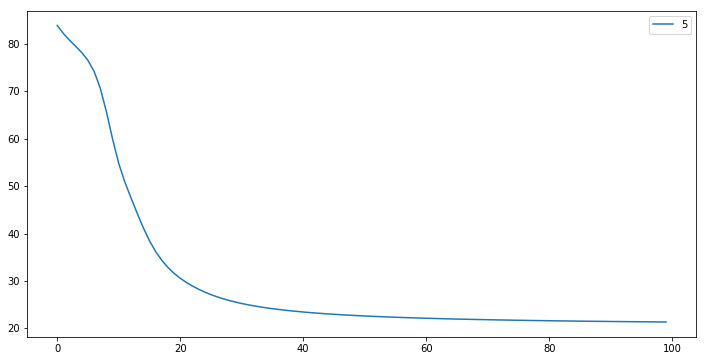

tensor([[[0.9255, 0.3588]]], grad_fn=<StackBackward>)


In [61]:
class LSTM2(nn.Module):
    def __init__(self, hidden_size: int, input_size: int):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(hidden_size=hidden_size, input_size=input_size)
        
    def forward(self, xs):
        batch_size, input_size, sequence_len = xs.shape
        xs = xs.permute(2, 0, 1)
        c = torch.zeros(size=(1, batch_size, self.hidden_size))
        h = torch.zeros(size=(1, batch_size, self.hidden_size))
        # print(xs.shape)
        # print(c.shape)
        # print(h.shape)
        out, (h, c) = self.lstm(xs, (h, c))
        return h


# Training on 5 numbers
train_xs = np.random.uniform(-1, 1, size=(5000, 2, 5))
train_ys = np.apply_along_axis(lambda x: np.sum(x), -1, train_xs)
# model1 = LSTMLayer(hidden_size=2, input_size=2)
model1 = LSTM2(hidden_size=2, input_size=2)
losses1 = train_rnn(model1, train_xs, train_ys)

'''
# Training on 15 numbers
train_xs = np.random.uniform(-1, 1, size=(5000, 2, 15))
train_ys = np.apply_along_axis(lambda x: np.sum(x), -1, train_xs)
model2 = RNNLayer(input_size=2, memory_size=2)
losses2 = train_rnn(model2, train_xs, train_ys)

# Training on 35 numbers
train_xs = np.random.uniform(-1, 1, size=(5000, 2, 35))
train_ys = np.apply_along_axis(lambda x: np.sum(x), -1, train_xs)
model3 = RNNLayer(input_size=2, memory_size=2)
losses3 = train_rnn(model3, train_xs, train_ys)

# Training on 55 numbers
train_xs = np.random.uniform(-1, 1, size=(5000, 2, 55))
train_ys = np.apply_along_axis(lambda x: np.sum(x), -1, train_xs)
model4 = RNNLayer(input_size=2, memory_size=2)
losses4 = train_rnn(model4, train_xs, train_ys)
'''

# Showing the losses over time
plt.figure(figsize=(12,6))
plt.plot(list(range(len(losses1))), losses1, label='5')
# plt.plot(list(range(len(losses2))), losses2, label='15')
# plt.plot(list(range(len(losses3))), losses3, label='35')
# plt.plot(list(range(len(losses4))), losses4, label='55')
plt.legend()
plt.show()

# Print the results
print(model1(test_xs))
# print(model2(test_xs))
# print(model3(test_xs))
# print(model4(test_xs))